In [115]:
import control as ctrl
import matplotlib.pyplot as plt 
import numpy as np 
import casadi 

s = ctrl.tf('s')

def pt2(w,d):
    return ctrl.tf(w**2,[1,2*w*d,w**2])

wn = 10
dn = 0.05
wd = 96
dd = 0.31

wd2 = 437
dd2 = 0.707


G = pt2(wd,dd)*1/pt2(wn,dn) * pt2(wd2,dd2) * ctrl.tf([1],[1,0])
#G =  pt2(wd2,dd2)

G

TransferFunction(array([1.7599703e+09, 1.7599703e+09, 1.7599703e+11]), array([1.00000000e+02, 6.77438000e+04, 2.36963479e+07, 1.70612072e+09,
       1.75997030e+11, 0.00000000e+00]))

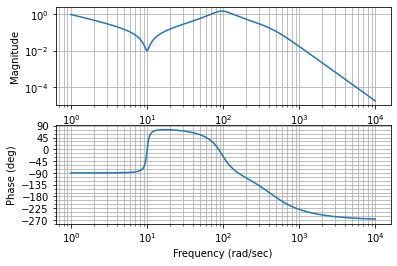

In [116]:
mag,phase,w = ctrl.bode(G)
mag = np.log10(mag)


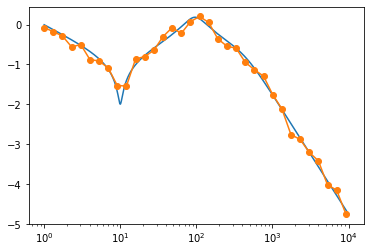

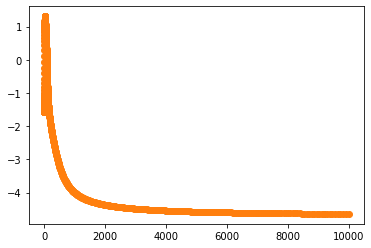

In [117]:
plt.semilogx(w,mag)

indx = np.arange(0,len(w),1)
indx = np.mod(indx,30)==0

ws = w[indx]
mags = mag[indx]
phases = phase[indx]

np.random.seed(1337)

mags += 0.1*np.random.randn(len(mags))

#phases = np.mod(phases,2*np.pi)

# Phase must start at within +/- 180 deg
if abs(phases[0]) >= np.pi:
    phases = np.mod(phases + np.pi,2*np.pi) - np.pi


plt.plot(ws, mags,'o-')
plt.figure()
plt.plot(ws, phases,'o-')
plt.plot(w, phase,'o-')

$$
G(s) = G_1(s) G_2(s) ... G_m(s)
$$

$$
|G(\omega)| = |G_1(\omega)| |G_2(\omega)| ... |G_m(\omega)|
$$


$$
\log(|G(\omega)|) = \log(|G_1(\omega)|) + \log(|G_2(\omega)|)  + ... + \log(|G_m(\omega)|) 
$$




$$
\angle{G(\omega)} = \angle{G_1(\omega)} + \angle{G_2(\omega)} + ... + \angle{G_m(\omega)}
$$


In [118]:
from typing import Protocol

class TfElement(Protocol):

    def get_log_mag(self,w):
        pass 

    def get_phase(self,w):
        pass

class Integrator(TfElement):
    def get_log_mag(self,w):
        return  -1.0*casadi.log10(w)

    def get_phase(self,w):
        return -1.0*casadi.atan2(w,1)

class PT1(TfElement):
    def __init__(self,tau):
        self.tau = tau

    def get_log_mag(self,w):
        return casadi.log10(casadi.sqrt(1 + (w*self.tau)**2))

    def get_phase(self,w):
        return casadi.atan2(w,1)

class PT2(TfElement):
    def __init__(self,wd,dd):
        self.wd = wd
        self.dd = dd

    def _parts(self,wi):
        t2Re = (self.wd**2 - wi**2)
        t2Im = (2*self.wd*wi*self.dd)
        return t2Re,t2Im

    def get_log_mag(self,w):
        t2Re,t2Im = self._parts(w)
        t2 = t2Re**2 + t2Im**2
        return casadi.log10(casadi.sqrt(t2)) - 2*casadi.log10(self.wd)

    def get_phase(self,w):
        t2Re,t2Im = self._parts(w)
        return casadi.atan2(t2Im,t2Re) 


In [119]:
# What model?
NoPT2_numer = 2
NoPT2_denom = 3
NoPT1_numer = 0
NoPT1_denom = 0
integrator_sys = True

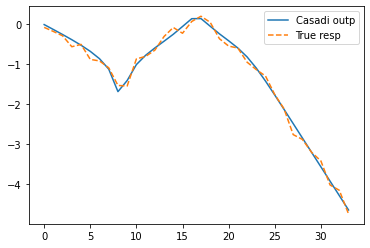

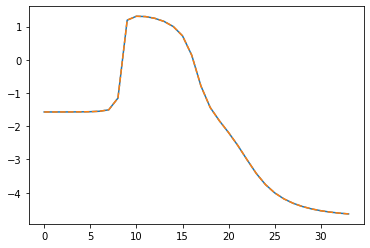

In [120]:
magis = []
phis = []
#G = pt2(wd,dd)*1/pt2(wn,dn) * pt2(wd2,dd2)

num_PT2s:list[TfElement] = [PT2(wn,dn)]
den_PT2s:list[TfElement] = [PT2(wd,dd),PT2(wd2,dd2)]

num_PT1s:list[TfElement] = []
den_PT1s:list[TfElement] = []

J = 0

    
for i in range(len(ws)):

    wi = ws[i]
    magi = 0
    phi = 0

    for pt2 in num_PT2s:
        magi += pt2.get_log_mag(wi)
        phi += pt2.get_phase(wi)

    for pt2 in den_PT2s:
        magi -= pt2.get_log_mag(wi)
        phi -= pt2.get_phase(wi)

    for pt1 in num_PT1s:
        magi += pt1.get_log_mag(wi)
        phi += pt1.get_phase(wi)

    for pt1 in den_PT1s:
        magi -= pt1.get_log_mag(wi)
        phi -= pt1.get_phase(wi)

    if integrator_sys:
        magi -= casadi.log10(wi)
        phi -= np.pi/2

    magis.append(magi)
    phis.append(phi)


plt.plot(magis,label="Casadi outp")
plt.plot(mags,'--',label="True resp")
plt.legend()

plt.figure()
plt.plot(phis)
plt.plot(phases,'--')

In [121]:
opti = casadi.Opti()


def create_PT1(opti):
    tau = opti.variable()
    opti.subject_to(tau>=0.1)
    opti.subject_to(tau <= 1e9)
    opti.set_initial(tau,10)

    return PT1(tau)

def create_PT2(opti):
    
    wd = opti.variable()
    dd = opti.variable()

    opti.subject_to(wd>=1)
    opti.subject_to(wd <= 1e9)
    opti.set_initial(wd,100)

    opti.subject_to(dd>=0.1) 
    # A lower damping introduces non-convexity, so might be a trick to keep up our sleves 
    # to raise this lower limit if we run into numerical issues
    opti.subject_to(dd <= 1.01)
    opti.set_initial(dd,0.9)

    return PT2(wd,dd)




# We don't want to estimate a model with a too small gain (k),
# maybe want to add a pre-check and scale up the freq. data.
k = opti.variable()
opti.subject_to(k>=0.8)
opti.subject_to(k <= 1e9)
opti.set_initial(k,100)


# Create the model elements
num_PT2s:list[TfElement] = [create_PT2(opti) for _ in range(NoPT2_numer)]
den_PT2s:list[TfElement] = [create_PT2(opti) for _ in range(NoPT2_denom)]

num_PT1s:list[TfElement] = [create_PT1(opti) for _ in range(NoPT1_numer)]
den_PT1s:list[TfElement] = [create_PT1(opti) for _ in range(NoPT1_denom)]

J = 0

for i in range(len(ws)):

    wi = ws[i]

    magi = casadi.log10(k)
    phi = 0

    for pt2 in num_PT2s:
        magi += pt2.get_log_mag(wi)
        phi += pt2.get_phase(wi)

    for pt2 in den_PT2s:
        magi -= pt2.get_log_mag(wi)
        phi -= pt2.get_phase(wi)

    for pt1 in num_PT1s:
        magi += pt1.get_log_mag(wi)
        phi += pt1.get_phase(wi)

    for pt1 in den_PT1s:
        magi -= pt1.get_log_mag(wi)
        phi -= pt1.get_phase(wi)

    if integrator_sys:
        magi -= casadi.log10(wi)
        phi -=  np.pi/2

    mag_true = mags[i]
    m_err = (mag_true - magi)**2
    ph_err = 180/np.pi*(phases[i] - phi)**2

    J += m_err + ph_err

opti.minimize(J);

opti.solver('ipopt');
sol = opti.solve();



This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       22
Number of nonzeros in Lagrangian Hessian.............:       66

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       22
        inequality constraints with only lower bounds:       11
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3065844e+03 0.00e+00 3.33e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [122]:
# Do some checks if we are at the boundary to numerical/convexity issues

if np.abs(sol.value(k)) < 0.9:
    print(f"k is {sol.value(k)}, might want to scale up your input data for better numerical accuracy")


pt2s = num_PT2s.copy()
pt2s.extend(den_PT2s.copy())

for p in pt2s:
    if sol.value(p.dd) < 0.1:
        print("You have one PT2 element with delta below 0.1, might want to do two iterations with a higher lower bound on d for better accuracy")

You have one PT2 element with delta below 0.1, might want to do two iterations with a higher lower bound on d for better accuracy


0.9475242161388063


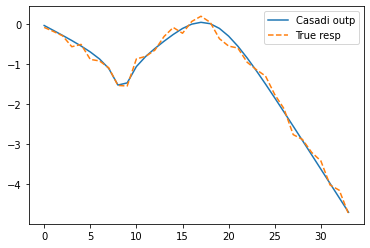

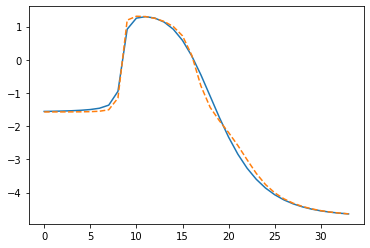

In [123]:

ks = sol.value(k)
print(ks)

num_PT2sols:list[TfElement] = [PT2(sol.value(p.wd),sol.value(p.dd)) for p in num_PT2s]
den_PT2sols:list[TfElement] = [PT2(sol.value(p.wd),sol.value(p.dd)) for p in den_PT2s]

num_PT1sols:list[TfElement] = [PT1(sol.value(p.tau)) for p in num_PT1s]
den_PT1sols:list[TfElement] = [PT1(sol.value(p.tau))  for p in den_PT1s]


magis = []
phis = []
for i in range(len(ws)):

    wi = ws[i]
    magi = casadi.log10(ks)
    phi = 0

    for pt2 in num_PT2sols:
        magi += pt2.get_log_mag(wi)
        phi += pt2.get_phase(wi)

    for pt2 in den_PT2sols:
        magi -= pt2.get_log_mag(wi)
        phi -= pt2.get_phase(wi)

    for pt1 in num_PT1sols:
        magi += pt1.get_log_mag(wi)
        phi += pt1.get_phase(wi)

    for pt1 in den_PT1sols:
        magi -= pt1.get_log_mag(wi)
        phi -= pt1.get_phase(wi)
        
    if integrator_sys:
        magi -= casadi.log10(wi)
        phi -=  np.pi/2

    magis.append(magi)
    phis.append(phi)

plt.plot(magis,label="Casadi outp")
plt.plot(mags,'--',label="True resp")
plt.legend()

plt.figure()
plt.plot(phis)
plt.plot(phases,'--')